# **Human In A Loop:**

Let's demonstrates a "human-in-the-loop" approach in a LangGraph-based chatbot that involves user approval before certain operations, like tool usage, are executed.

## **Purpose**

* Introduce breakpoints that stop the graph at specific nodes.

* Allow for human intervention for "approval" before the chatbot proceeds with certain operations.

* Enable user feedback to dynamically control the flow of the graph.

## **Motivation for Human-in-the-Loop with Breakpoints**

* **Pause Execution** before a critical action (like using a tool).

* Allow the user to **approve, debug, or edit** the state before proceeding.

* **interrupt_before=["tools"]** is used to trigger this pause before executing tool-related nodes.

In [1]:
%%capture --no-stderr
%pip install -qU langgraph langchain-google-genai langchain_core langchain_community

In [2]:
# For Colab, use this:
from google.colab import userdata
GEMINI_API_KEY = userdata.get("GEMINI_API_KEY")

In [3]:
from langchain_google_genai import ChatGoogleGenerativeAI

gemini_flash: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(
    model='gemini-1.5-flash',
    temperature=0,
    api_key=GEMINI_API_KEY
)

In [4]:
def multiply(a: int, b: int) -> int:
    """Multiply two numbers."""
    return a * b

def add(a: int, b: int) -> int:
    """Add two numbers."""
    return a + b

def subtract(a: int, b: int) -> int:
    """Subtract two numbers."""
    return a - b

def divide(a: int, b: int) -> float:
    """Divide two numbers."""
    return a / b

tools = [add, subtract, multiply, divide]

In [5]:
llm_with_tools = gemini_flash.bind_tools(tools)

In [6]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

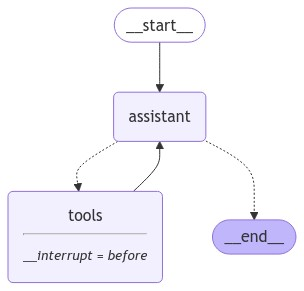

In [14]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver

builder = StateGraph(MessagesState)

builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", tools_condition,)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["tools"], checkpointer=memory)

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

* **Memory Checkpointing:** MemorySaver is used to save the graph's state so it can resume where it left off.

* **Interrupt Before tools:** This specifies that the graph should pause right before executing the tools node. This pause allows for a human-in-the-loop scenario where the user can approve or modify the state before the tools node runs.

### **Starting Execution and Streaming the Graph:**

The execution of the graph begins with an initial input from the user, asking to "Multiply 2 and 3". The graph processes nodes and streams back full state updates after each node, up until it hits the breakpoint.

In [26]:
# Thread
thread = {"configurable": {"thread_id": "1"}}

# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
{'name': 'add', 'description': 'Add two numbers.', 'parameters': {'type_': 6, 'description': 'Add two numbers.', 'properties': {'b': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}, 'a': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}}, 'required': ['a', 'b'], 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0'}}
{'name': 'subtract', 'description': 'Subtract two numbers.', 'parameters': {'type_': 6, 'description': 'Subtract two numbers.', 'properties': {'b': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}, 'a': {'type_': 3, 'format_': '', 'description': '', 'nullabl

* **Initial Input:** The conversation starts with the user asking to "Multiply 2 and 3".

* **Thread ID:** The thread allows tracking of individual conversation sessions.

* **Stream Mode:** stream_mode="values" provides full state information after each node executes, and here it streams until it hits the breakpoint (before tools).

* **event['messages'][-1].pretty_print():** This displays the latest message in the state, so you see what each node has added or modified in the messages.

### **Checking the State and Getting the Next Node:**

To inspect the paused state, you retrieve the current state and identify the next node that the graph is waiting to execute:

In [19]:
state = graph.get_state(thread)
state.next

('tools',)

* **graph.get_state(thread):** This retrieves the current state of the graph for the specified thread. Since the execution paused before the tools node, this state reflects everything that happened up to that point.

* **state.next:** This shows the next node that the graph is set to execute once it resumes.

### **Resuming Execution After Approval:**

After reviewing the state, the graph can resume from the paused point. By passing None as the input to graph.stream(), it continues from the last saved checkpoint.

And then it will proceed to execute the following steps in the graph, which start with the tool node.

We see that the tool node is run with this tool call, and it's passed back to the chat model for our final answer.

In [20]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  multiply (baedecea-9287-416f-91b5-67970a7af916)
 Call ID: baedecea-9287-416f-91b5-67970a7af916
  Args:
    b: 3.0
    a: 2.0
================================= Tool Message =================================
Name: multiply

6
{'name': 'add', 'description': 'Add two numbers.', 'parameters': {'type_': 6, 'description': 'Add two numbers.', 'properties': {'b': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}, 'a': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}}, 'required': ['a', 'b'], 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0'}}
{'name': 'subtract', 'description': 'Subtract two numbers.', 'parameters': {'type_': 6, 'description': 'Subtract two numbers.', 'properti

* **graph.stream(None, ...):** By passing None, the graph resumes from the last saved state. This avoids restarting from scratch, which is useful for workflows where a human intervenes and approves each step.

* **Stream Events:** This resumes the graph, allowing it to process the tools node and subsequent nodes. The latest message is printed after each node, so the entire tool operation’s output is visible.

## **Example of Human Approval Step:**

In [23]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "2"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

# Get user feedback
user_approval = input("Do you want to call the tool? (yes/no): ")

# Check approval
if user_approval.lower() == "yes":

    # If approved, continue the graph execution
    for event in graph.stream(None, thread, stream_mode="values"):
        event['messages'][-1].pretty_print()

else:
    print("Operation cancelled by user.")

================================ Human Message =================================

Multiply 2 and 3
{'name': 'add', 'description': 'Add two numbers.', 'parameters': {'type_': 6, 'description': 'Add two numbers.', 'properties': {'b': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}, 'a': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}}, 'required': ['a', 'b'], 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0'}}
{'name': 'subtract', 'description': 'Subtract two numbers.', 'parameters': {'type_': 6, 'description': 'Subtract two numbers.', 'properties': {'b': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}, 'a': {'type_': 3, 'format_': '', 'description': '', 'nullabl

* **Start the Graph:** Initiates the graph with the same multiplication request.

* **Stream Until Breakpoint:** Streams state until it pauses before the tools node.

* **User Approval:** The code asks the user if they want to allow the tool usage. If "yes", it resumes the graph; if "no", it cancels the operation.

## **Key Takeaways:**

* **Human-in-the-Loop:** Pausing for user approval or intervention during critical steps.

* **Breakpoints:** Pausing the graph at predefined nodes to allow for user decisions.

* **Resuming Execution:** Using None to continue execution from the paused state.

* **Streaming State:** Provides visibility into each node's execution state, facilitating real-time human monitoring and control.